## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
# from <TC_Env> import <TicTacToe> - import your class from environment file
from TCGame_Env1 import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [2]:
env = TicTacToe()
f, s = env.action_space([np.nan for _ in range(9)])
res = [l for l in s]
len(res)

36

In [3]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [4]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env

    return valid_Actions

In [5]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
#     print(state, valid_act)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [6]:
def get_epsilon(time):
    return min_epsilon + (max_epsilon - min_epsilon) * np.exp(decay_rate*time)

In [7]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy

def epsilon_greedy(state, time):   
    epsilon = get_epsilon(time)
    z = np.random.random()
        
    if z > epsilon:
        action = max(Q_dict[state],key=Q_dict[state].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
        action = random.choice(list(Q_dict[state]))
    
    return action



#### Tracking the state-action pairs for checking convergence - write your code here

In [8]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)

Q_dict = collections.defaultdict(dict)

States_track = collections.defaultdict(dict)


In [9]:
# Initialise states to be tracked

def initialise_tracking_states():
    sample_q_values = [('x-7-x-1-8-4-3-x-6', (2, 5)),
                       ('8-3-x-2-7-5-6-4-1', (2, 9)),
                       ('x-6-2-4-8-7-9-5-3', (0, 1)),  
                       ('x-x-8-4-x-9-5-x-x', (8, 3)),
                       ('6-x-1-x-x-x-x-x-x', (5, 5)),
                       ('3-x-x-4-x-5-x-8-x', (3, 3)),
                       ('x-x-x-x-x-x-x-x-x', (0, 1)),
                       ('7-x-x-x-x-x-x-8-x', (1, 1)),
                       ('x-2-x-x-x-x-x-x-9', (0, 5))]    
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []    #this is an array which will have appended values of that state-action pair for every 2000th episode         
  

In [10]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
#     print(name, name + '.pkl')
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [11]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [12]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [13]:
#Defining parameters for the experiment

#EPISODES = 20
EPISODES = 5000000
LR = 0.01 
GAMMA = 0.91
max_epsilon = 1.0
min_epsilon = 0.001 
decay_rate = -0.000001
threshold = 100000
policy_threshold = 100000

### Q-update loop ---write your code here

In [14]:
start_time = time.time()

for episode in range(EPISODES):
    env = TicTacToe()
    
    initial_state = env.state
    curr_state = env.state
    add_to_dict(curr_state)
    
    reward = None
    isTerminal = False
    
    while isTerminal == False:
        formatted_curr_state = Q_state(curr_state)
        curr_action = epsilon_greedy(formatted_curr_state, episode)
        next_state, reward, isTerminal = env.step(curr_state, curr_action)
        
        formatted_next_state = Q_state(next_state)
        add_to_dict(next_state)
        
        if isTerminal:            
            Q_dict[formatted_curr_state][curr_action] += LR * ( reward - Q_dict[formatted_curr_state][curr_action] )
#             print(formatted_curr_state, formatted_next_state, curr_action, reward)
        else:
            max_next = max(Q_dict[formatted_next_state],key=Q_dict[formatted_next_state].get)
            Q_dict[formatted_curr_state][curr_action] += \
                LR * ((reward + (GAMMA*(Q_dict[formatted_next_state][max_next]))) - Q_dict[formatted_curr_state][curr_action] )            


        curr_state = next_state
    
    #TRACKING Q-VALUES
    if (episode == threshold-1):    
        initialise_tracking_states()
      
    if ((episode+1) % threshold) == 0:
        save_tracking_states()
        save_obj(States_track,'States_tracked')   
    
#     SAVING POLICY
    if ((episode+1)% policy_threshold ) == 0:
        save_obj(Q_dict,'Policy')    
    
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')

print("Elapsed time: ", elapsed_time)

Elapsed time:  4925.354967594147


In [15]:
len(Q_dict)    

2261347

In [16]:
States_track

defaultdict(dict,
            {'x-7-x-1-8-4-3-x-6': {(2, 5): [0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0]},
             '8-3-x-2-7-5-6-4-1': {(2, 9): []},
             'x-6-2-4-8-7-9-5-3': {(0, 1): []},
             'x-x-8-4-x-9-5-x-x': {(8, 3): [0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0

#### Check the Q-dictionary

In [17]:
# notebook crashes if we try to print Q_dict, so keeping it commented
# Q_dict

In [18]:
#Q_dict.values()

In [19]:
len(Q_dict)

2261347

In [20]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
Q_dict['6-x-1-x-x-x-x-x-x']


{(1, 3): -0.4814884995508241,
 (1, 5): -0.4808457579193582,
 (1, 7): -0.48402689788685155,
 (1, 9): -0.44864521337870505,
 (3, 3): -0.5478605242339336,
 (3, 5): -0.484361653673427,
 (3, 7): -0.5959331148547093,
 (3, 9): -0.5210204108934746,
 (4, 3): -0.5092156076126377,
 (4, 5): -0.5447354774942881,
 (4, 7): -0.6269384891902557,
 (4, 9): -0.48291541078142614,
 (5, 3): -0.5933511141337188,
 (5, 5): -0.5371602205824756,
 (5, 7): -0.5079335858818902,
 (5, 9): -0.5384885207148934,
 (6, 3): -0.5634772535005165,
 (6, 5): -0.578338161283605,
 (6, 7): -0.5208410959035771,
 (6, 9): -0.48019091646503714,
 (7, 3): -0.5369371563420029,
 (7, 5): -0.48387799813072746,
 (7, 7): -0.4827433660212169,
 (7, 9): -0.5749342949196095,
 (8, 3): -0.5383586826307738,
 (8, 5): -0.630065366892856,
 (8, 7): -0.5470392262818461,
 (8, 9): -0.5118870294627034}

In [32]:
Q_dict['6-x-x-x-x-x-7-8-9']

{(1, 1): -0.01,
 (1, 3): -0.0199,
 (1, 5): -0.1,
 (2, 1): -0.00909,
 (2, 3): -0.01,
 (2, 5): -0.1099,
 (3, 1): 0,
 (3, 3): -0.01,
 (3, 5): -0.01,
 (4, 1): 0,
 (4, 3): 0,
 (4, 5): 0,
 (5, 1): 0,
 (5, 3): 0,
 (5, 5): 0}

#### Check the states tracked for Q-values convergence
(non-evaluative)

<function matplotlib.pyplot.show(*args, **kw)>

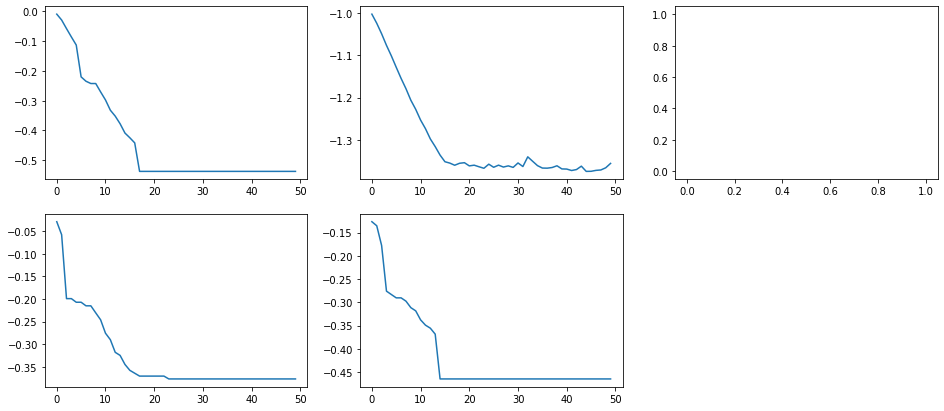

In [21]:
   
plt.figure(0, figsize=(16,7))

x_axis = np.asarray(range(0, len(States_track['6-x-1-x-x-x-x-x-x'][(5, 5)])))
plt.subplot(231)
plt.plot(x_axis,np.asarray(States_track['6-x-1-x-x-x-x-x-x'][(5, 5)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(0, 1)])))
plt.subplot(232)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(0, 1)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['8-3-x-2-7-5-6-4-1'][(2, 9)])))
plt.subplot(233)
plt.plot(x_axis,np.asarray(States_track['8-3-x-2-7-5-6-4-1'][(2, 9)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['7-x-x-x-x-x-x-8-x'][(1, 1)])))
plt.subplot(234)
plt.plot(x_axis,np.asarray(States_track['7-x-x-x-x-x-x-8-x'][(1, 1)]))
plt.show


x_axis = np.asarray(range(0, len(States_track['x-2-x-x-x-x-x-x-9'][(0, 5)])))
plt.subplot(235)
plt.plot(x_axis,np.asarray(States_track['x-2-x-x-x-x-x-x-9'][(0, 5)]))
plt.show

### Epsilon - decay check

In [22]:
time = np.arange(0,5000000)
epsilon = []
for i in time:
    epsilon.append(get_epsilon(i))    

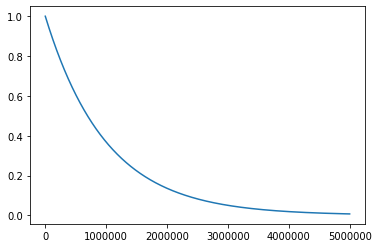

In [23]:
plt.plot(time, epsilon)
plt.show()